<a href="https://colab.research.google.com/github/viraatdas/Purdue_CompVis_Workshop/blob/8_preprocessor(6)-main/speed_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
print("wus good")

wus good


Import video files

In [44]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Import libraries

In [0]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # More on this later

Organie file paths

In [46]:
train_video = "./drive/My Drive/speed_predict/train.mp4"
labels = "./drive/My Drive/speed_predict/train.txt"
output_path = "./drive/My Drive/speed_predict/data_preprocessed"

if not os.path.exists(output):
  os.mkdir(output)
  print(f"Directory {output} created")
FRAME_RATE = 20

Directory ./drive/My Drive/speed_predict/data_preprocessed created


Preprocessor class

In [0]:
# Input for the Optical Flow Farneback Method
flow_mat = None
image_scale = 0.5
nb_images = 1
win_size = 15
nb_iterations = 2
deg_expansion = 5
STD = 1.3

In [0]:
class PreProcessor:
  def __str__(self):
    # Indicate class description
    return "Pre-processor class"
  
  def grayscale(self, frame):
    # Converts frame to gray scale
    return cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  
  def plot_training_speed(self, data):
    # plot labels
    data = np.loadtxt(data)
    plt.plot(data)
    plt.show()
  def generate_images(self, file_path, label_path, gray=False):
    # Takes the video file and generates images for each 
    # of it's frames. The time for each frame and the image path
    # for the corresponding frame is stored in a csv

    # Load the speeds
    speeds = np.loadtxt(label_path)
    
    # Video file
    video_capture = cv2.VideoCapture(file_path)

    # Check if number of label is same as number of frames
    if len(speeds) == video_capture.get(cv2.CAP_PROP_FRAME_COUNT):
      print("Labels are equal to number of frames")
    else:
      print("Check if labels are equal to number of frames")
      return

    with open("processed.csv", "w+") as file:
      writer = csv.writer(file)
      time_between_frames = 1 / FRAME_RATE
      time_elapsed = 0

      for idx, i in enumerate(speeds):
        ret, frame = video_capture.read()
        time_elapsed += time_between_frames
        if gray:
          frame = self.grayscale(frame)
        if ret:
          # cv2_imshow(frame)
          image_path = f"{output_path}/{str(round(time_elapsed,4))}.jpg"
          cv2.imwrite(image_path, frame)
          writer.writerow([image_path, time_elapsed, speeds[idx]])
        if cv2.waitKey(1) & 0xFF == ord('q'):
          break
      video_capture.release()
      cv2.destroyAllWindows()

  def shuffle_frame_pairs(self, dataframe, val_split=1):
    # Shuffles pairs of frames from the video 
    # We need pair of frames for the optical flow
    # returns training and validation dataframe

    training_data = pd.DataFrame()
    validation_data = pd.DataFrame()
    df_len = dataframe.shape[0]

    for i in range(df_len - 1):
      idx1 = np.random.randint(df_len - 1)
      idx2 = idx1 + 1
      row1 = dataframe.iloc[[idx1]].reset_index()
      row2 = dataframe.iloc[[idx2]].reset_index()
      
      # 90 - 10 split for training and validating
      randInt = np.random.randint(9)
      if 0 <= randInt <= val_split:
        valid_frame = [validation_data, row1, row2]
        validation_data = pd.concat(
            valid_frames, axis=0, join='outer', ignore_index=False)
      if randInt >= val_split + 1:
        train_frame = [training_data, row1, row2]
        training_data = pd.concat(
            train_frames, axis=0, join='outer', ignore_index=False)
    return training_data, validation_data

  def adjust_brightness(self, image, factor, slice):
    # Convert frame to hue, saturation, value model

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    hsv[:,:,slice] = hsv[:,:,slice] * factor
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb
  
  def crop_sky_dashboard(self, frame):
  
    frame = frame[100:440, :-90]
    image = cv2.resize(frame, (220,66), interpolation=cv2.INTER_AREA)
    return image
  
  def optical_flow(self, im_c, im_n):
    # im_c refers to the current image
    # im_n refers to the new_image
    gray_c = self.grayscale(im_c)
    gray_n = self.grayscale(im_n)

    hsv = np.zeros_like(im_c)
    # set saturation - hue, saturation, value
    hsv[:,:,1] = cv2.cvtColor(im_n, cv2.COLOR_RGB2HSV)

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_c, gray_n, 
                                        flow_mat,
                                        image_scale,
                                        nb_images,
                                        win_size,
                                        nb_iterations,
                                        deg_expansion,
                                        STD,
                                        0)
    # convert from cartesian to polar
    mag, ang = cv2.carToPolar(flow[...,0], flow[...,1])
    # hue corresponds to direction
    hsv[:,:,0] = ang*(180/ np.pi / 2)
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    # convert HSV to int32's
    hsv = np.asarray(hsv, dtype=np.float32)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    # cv2.imwrite("./flow.jpg", rgb_flow)
    return rgb_flow

  def preprocess_image_valid_from_path(self, image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = self.adjust_brightness(img, 0.2, 2)
    img = self.crop_sky_dashboard(img)
    return img, speed
  
  def preprocess_image_from_path(self, image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = self.adjust_brightness(img,0.2,2)
    img = self.crop_sky_dashboard(img)
    
    return img, speed

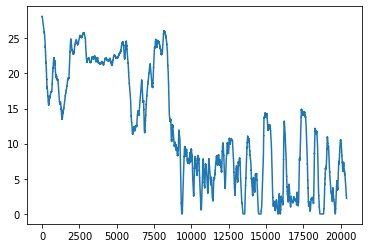

Labels are equal to number of frames


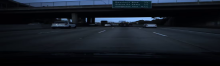

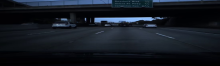

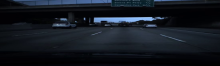

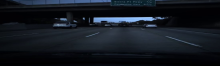

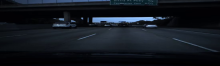

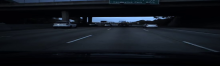

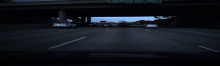

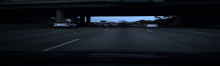

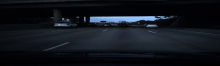

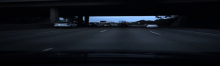

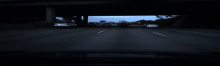

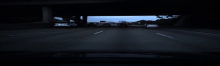

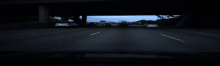

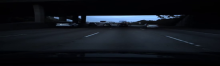

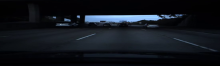

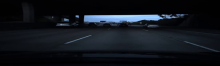

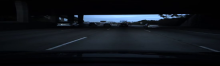

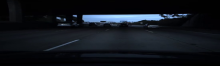

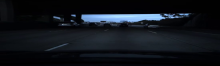

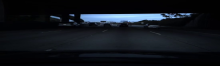

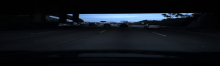

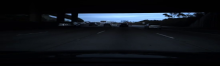

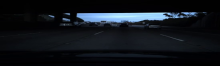

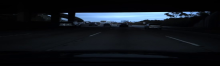

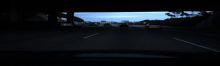

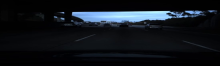

KeyboardInterrupt: ignored

In [62]:
preprocessor = PreProcessor()
preprocessor.plot_training_speed(labels)
preprocessor.generate_images(train_video, labels)